In [84]:
import pandas as pd
import numpy as np
import os
import graphviz
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from sklearn.ensemble import GradientBoostingClassifier

os.chdir("/home/william/Desktop")

In [85]:
datosTicTacToe = pd.read_csv("tic-tac-toe.csv")

In [86]:
for x in datosTicTacToe:
    if x != " Gana-x":
        datosTicTacToe[x] = datosTicTacToe[x].astype('category')
datosTicTacToe.dtypes

cuadro-superior-izquierdo     category
 cuadro-superior-medio        category
 cuadro-superior-derecho      category
 cuadro-medio-izquierdo       category
 cuadro-medio-medio           category
  cuadro-medio-derecho        category
 cuadro-inferior-izquierdo    category
 cuadro-inferior-medio        category
 cuadro-inferior-derecho      category
 Gana-x                         object
dtype: object

In [87]:
datosTicTacToePosiblesResultados = list(set(datosTicTacToe.iloc[:, -1]))

In [88]:
class PrediccionBase:
    def __init__(self, datos):
        self.__datos = self.cleaning(datos)
        self.__precisionGlobal = 0
        self.__error_global = 0
        self.__verdaderosNegativos = 0
        self.__falsosPositivos = 0
        self.__falsosNegativos = 0
        self.__verdaderosPositivos = 0
        self.__reporte = 0
        self.__precision_category = 0

    @property
    def datos(self):
        return self.__datos

    @property
    def reporte(self):
        return self.__reporte

    def cleaning(self, datos):
        datos = datos.replace({'x': 0, 'o': 1, 'b': 2})
        return datos

    def entrenamiento(self):
        pass

    def generacionReporte(self, nombreDelModelo):
        dict = {
            "Modelo": [nombreDelModelo],
            "Precision Global": [self.__precisionGlobal],
            "Error Global": [self.__error_global],
            "Verdaderos Positivos": [self.__verdaderosPositivos],
            "Verdaderos Negativos": [self.__verdaderosNegativos],
            "Falsos Negativos": [self.__falsosNegativos],
            "Falsos Positivos": [self.__falsosPositivos]}
        self.__reporte = pd.DataFrame(dict).join(self.__precision_category)

    def analsis(self, MC, modelo):
        self.__verdaderosNegativos, self.__falsosPositivos, self.__falsosNegativos, self.__verdaderosPositivos = MC.ravel()
        self.__precisionGlobal = np.sum(MC.diagonal()) / np.sum(MC)
        self.__error_global = 1 - self.__precisionGlobal
        self.__precision_category = pd.DataFrame(MC.diagonal() / np.sum(MC, axis=1)).T
        self.__precision_category.columns = ["Precision Positiva (PP)", "Precision Negativa (PN)"]
        self.generacionReporte(modelo)
        return {"Matriz de Confusión": MC,
                "Precisión Global": self.__precisionGlobal,
                "Error Global": self.__error_global,
                "Precisión por categoría": self.__precision_category}

class PrediccionADABoosting(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)
        self.__instancia = None
        self.__instancia_potenciacion = None
        self.__x_train = []


    def obtenerVariablesImportantes(self):
        importancia =  self.__instancia_potenciacion.feature_importances_
        print(importancia)
        etiquetas = self.__x_train.columns.values
        y_pos = np.arange(len(etiquetas))
        plt.figure(figsize=(10,8))
        plt.barh(y_pos, importancia, align='center', alpha=0.5)
        plt.yticks(y_pos, etiquetas)


    def entrenamiento(self, train_size=0.75):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]
        self.__instancia = DecisionTreeClassifier(min_samples_split = 2, max_depth=None,
                                        criterion="gini",splitter="best")
        self.__instancia_potenciacion = AdaBoostClassifier(base_estimator=self.__instancia,
                                            n_estimators=100, random_state=0)
        self.__x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        self.__instancia_potenciacion.fit(self.__x_train,y_train)
        prediccion = self.__instancia_potenciacion.predict(x_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, "Arbol de Decisiones")
        for k in indices:
            print("\n%s:\n%s" % (k, str(indices[k])))


class PrediccionXGBoosting(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)
        self.__instancia = None
        self.__instancia_potenciacion = None
        self.__x_train = []

    def obtenerVariablesImportantes(self):
        importancia =  self.__instancia_potenciacion.feature_importances_
        print(importancia)
        etiquetas = self.__x_train.columns.values
        y_pos = np.arange(len(etiquetas))
        plt.figure(figsize=(10,8))
        plt.barh(y_pos, importancia, align='center', alpha=0.5)
        plt.yticks(y_pos, etiquetas)

    def entrenamiento(self, train_size=0.75):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]

        self.__instancia_potenciacion = GradientBoostingClassifier(n_estimators=10, random_state=0,
                                                    min_samples_split=2, max_depth = None)

        self.__x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        self.__instancia_potenciacion.fit(self.__x_train,y_train)
        prediccion = self.__instancia_potenciacion.predict(x_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, "Arbol de Decisiones")
        for k in indices:
            print("\n%s:\n%s" % (k, str(indices[k])))

class PrediccionRandomForest(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)
        self.__instancia = None
        self.__instancia_potenciacion = None
        self.__x_train = []

    def obtenerVariablesImportantes(self):
        importancia =  self.__instancia_potenciacion.feature_importances_
        print(importancia)
        etiquetas = self.__x_train.columns.values
        y_pos = np.arange(len(etiquetas))
        plt.figure(figsize=(10,8))
        plt.barh(y_pos, importancia, align='center', alpha=0.5)
        plt.yticks(y_pos, etiquetas)

    def entrenamiento(self, train_size=0.75):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]

        self.__instancia_potenciacion = RandomForestClassifier(n_estimators=10, random_state=0)

        self.__x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        self.__instancia_potenciacion.fit(self.__x_train ,y_train)
        prediccion = self.__instancia_potenciacion.predict(x_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, "Arbol de Decisiones")
        for k in indices:
            print("\n%s:\n%s" % (k, str(indices[k])))

In [89]:
prediccionADABosting = PrediccionADABoosting(datos=datosTicTacToe)
prediccionADABosting.entrenamiento()
prediccionADABosting.reporte


Matriz de Confusión:
[[ 69  17]
 [  9 145]]

Precisión Global:
0.8916666666666667

Error Global:
0.10833333333333328

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.802326                 0.941558


,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,Arbol de Decisiones,0.891667,0.108333,145,69,9,17,0.802326,0.941558


[0.12750074 0.07883277 0.07582998 0.097696   0.13403044 0.12201971
 0.16942481 0.08187425 0.1127913 ]


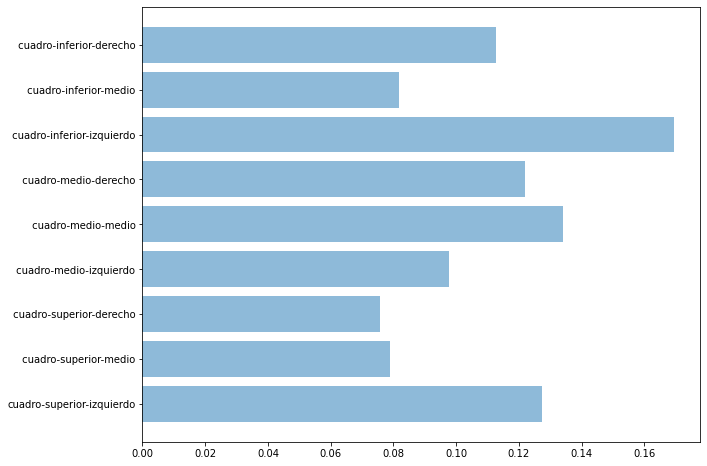

In [90]:
prediccionADABosting.obtenerVariablesImportantes()

In [91]:
prediccionXGBoosting = PrediccionXGBoosting(datos=datosTicTacToe)
prediccionXGBoosting.entrenamiento()
prediccionXGBoosting.reporte


Matriz de Confusión:
[[ 66  20]
 [  7 147]]

Precisión Global:
0.8875

Error Global:
0.11250000000000004

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.767442                 0.954545


,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,Arbol de Decisiones,0.8875,0.1125,147,66,7,20,0.767442,0.954545


[0.12978171 0.07135578 0.08045075 0.10440652 0.13403044 0.11617587
 0.16989764 0.08491996 0.10898133]


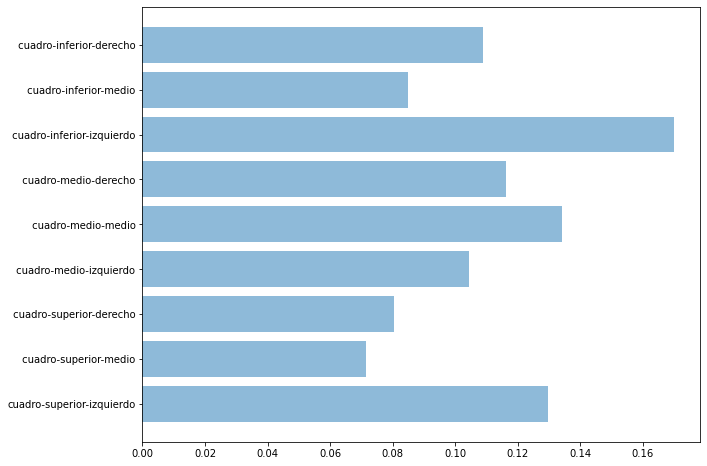

In [92]:
prediccionXGBoosting.obtenerVariablesImportantes()

In [93]:
prediccionRandomForest = PrediccionRandomForest(datos=datosTicTacToe);
prediccionRandomForest.entrenamiento()
prediccionRandomForest.reporte


Matriz de Confusión:
[[ 75  11]
 [  2 152]]

Precisión Global:
0.9458333333333333

Error Global:
0.054166666666666696

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.872093                 0.987013


,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,Arbol de Decisiones,0.945833,0.054167,152,75,2,11,0.872093,0.987013


[0.12307776 0.1080632  0.10836162 0.08515583 0.13403747 0.10309665
 0.11732241 0.10265419 0.11823087]


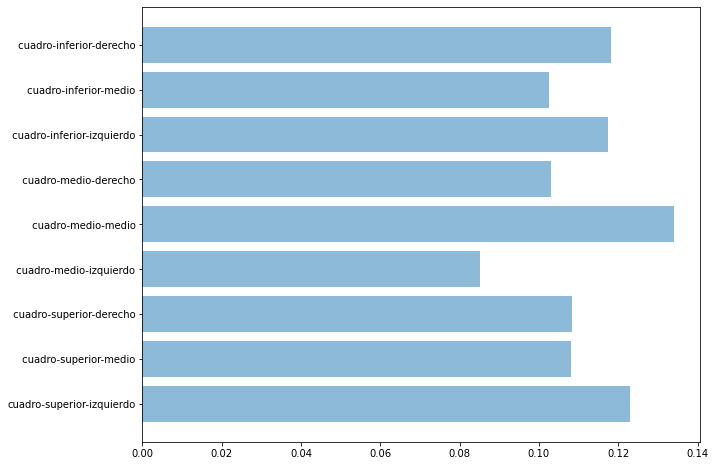

In [94]:
prediccionRandomForest.obtenerVariablesImportantes()
